# 1 实验内容
使用卷积神经网络（CNN）对CIFAR-10数据集进行分类

# 2 CIFAR-10数据集

## 2.1 下载CIFAR数据集

In [1]:
import urllib.request
import os
import tarfile

# 下载
url='http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filepath = 'data/cifar-10-python.tar.gz'
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url,filepath)
    print('下载:',result)
else:
    print('数据文件已存在.')

# 解压
if not os.path.exists('data/cifar-10-batches-py'):
    tfile = tarfile.open('data/cifar-10-python.tar.gz','r:gz')
    result = tfile.extractall('data/')
    print('解压到 ./data/cifar-10-batches-py/')
else:
    print('目录已存在.')    

数据文件已存在.
目录已存在.


## 2.2 导入CIFAR数据集

In [2]:
import numpy as np
import pickle as p

def load_CIFAR_batch(filename):
    '''加载单个批次数据'''
    with open(filename,'rb') as f:
        # 一个样本由标签和图像数据组成
        # <1 x label><3072 x pixel> （3072=32x32x3）
        # ...
        # <1 x label><3072 x pixel>
        data_dict = p.load(f, encoding='bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
        
        # 把原始数据结构调整为：BWHC（批次/宽度/高度/通道）
        images = images.reshape(10000,3,32,32)
        # tensorflow处理图像数据的结构：BWHC
        # 把通道数据C移动到最后一个维度
        images = images.transpose(0,2,3,1)
        labels = np.array(labels)
        return images, labels
    
def load_CIFAR_data(data_dir):
    '''加载CIFAR数据'''
    images_train = []
    labels_train =[]
    
    for i in range(5):
        f = os.path.join(data_dir,'data_batch_%d'%(i+1))
        print('加载 ',f)
        # 调用load_CIFAR_batch（）获得批量的图像及其对应的标签
        image_batch, label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch, label_batch
        
    Xtest, Ytest = load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('完成加载 CIFAR-10 数据集.')
    
    # 返回训练集的图像和标签
    return Xtrain, Ytrain, Xtest, Ytest

data_dir = 'data/cifar-10-batches-py/'
Xtrain, Ytrain, Xtest, Ytest = load_CIFAR_data(data_dir)

加载  data/cifar-10-batches-py/data_batch_1
加载  data/cifar-10-batches-py/data_batch_2
加载  data/cifar-10-batches-py/data_batch_3
加载  data/cifar-10-batches-py/data_batch_4
加载  data/cifar-10-batches-py/data_batch_5
完成加载 CIFAR-10 数据集


## 2.3 显示数据集信息

In [3]:
print('训练数据的shape:', Xtrain.shape)
print('训练标签的shape:',Ytrain.shape)
print('测试数据的shape:',Xtest.shape)
print('测试标签的shape:',Ytest.shape)

训练数据的shape: (50000, 32, 32, 3)
训练标签的shape: (50000,)
测试数据的shape: (10000, 32, 32, 3)
测试标签的shape: (10000,)


## 2.4 查看单项image和label

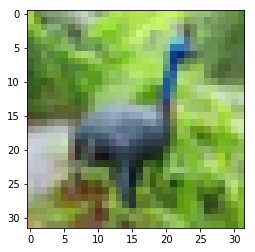

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# 查看image
plt.imshow(Xtrain[6])

In [5]:
# 查看label
# 对应的类别信息可查看：http://www.cs.toronto.edu/~kriz/cifar.html
print(Ytrain[6])

2


## 2.5 查看多项image和label

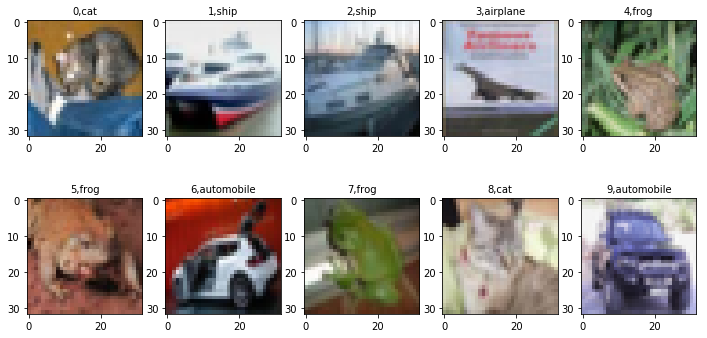

In [6]:
# 定义标签字典， 每一个数字所代表的图像类别的名称
label_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

# 定义显示图像数据及其对应标签的函数
def plot_images_labels_prediction(images, labels, prediction,index,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    
    # 最多输出10幅图像
    if num > 10:
        num = 10
        
    for i in range(0,num):
        ax = plt.subplot(2,5,1+i)
        ax.imshow(images[index],cmap = 'binary')
        
        # 子图标题
        title = str(i)+','+label_dict[labels[index]]
        if len(prediction) > 0:
            title+='=>'+label_dict[prediction[index]]
        ax.set_title(title, fontsize=10)
        
        index = index + 1
    plt.show()

# 显示图像数据及其对应标签
plot_images_labels_prediction(Xtest,Ytest,[],0,10)

# 3 数据预处理

## 3.1 图像数据预处理

In [7]:
# 查看图像数据信息
# 显示第一个图的第一个像素点
Xtrain[0][0][0]

array([59, 62, 63], dtype=uint8)

In [8]:
# 将图像进行数字标准化/归一化
Xtrain_normalize = Xtrain.astype('float32')/255.0
Xtest_normalize = Xtest.astype('float32')/255.0

In [9]:
# 查看预处理后的图像数据信息
Xtrain_normalize[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

## 3.2 标签数据预处理

In [10]:
# 查看标签数据
Ytrain[:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

**独热编码（One-Hot Encoding）**  

    +能够处理非连续型数值特征
    +在一定程度上能够扩充特征
    +易于计算样本间的相似性

In [11]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1,1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1,1)
Ytest_onehot = encoder.transform(Ytest_reshape)

/home/zhaoxt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [12]:
Ytrain_onehot.shape

(50000, 10)

In [13]:
Ytrain[:5]

array([6, 9, 9, 4, 1])

In [14]:
Ytrain_onehot[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

# 4 建立CIFAR-10图像分类模型

In [15]:
# 导入必要包
import tensorflow as tf
# 清空计算图
tf.reset_default_graph()

ModuleNotFoundError: No module named 'tensorflow'

## 4.1 定义共享函数

In [ ]:
# 定义权值
def weight(shape):
    # 在构建模型时，需要使用tf.Variable来创建一个变量
    # 在训练时，这个变量不断更新
    # 使用函数tf.truncated_normal(截断的正态分布)生成标准差为0.1的随机数来初始化权值
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name = 'W')

# 定义偏置
# 初始化为0.1
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape = shape), name='b')

# 定义卷积操作
# 步长为1， padding为“SAME”
def conv2d(x,W):
    # tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, name=None)
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding="SAME")

# 定义池化操作
# 步长为2， 即原尺寸的长和宽各除以2
def max_pool_2x2(x):
    # tf.nn.max_pool(value,ksize,strides,padding, name=None)
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

## 4.2 定义网络结构

In [ ]:
# 输入层
# 输入32x32图像，通道3（RGB）
with tf.name_scope("input_layer"):
    x = tf.placeholder(tf.float32, shape=[None,32,32,3], name='X')

# 第1个卷积层
# 输入通道：3，输出通道：32，卷积后图像尺寸不变，仍为32x32
with tf.name_scope('conv_1'):
    # [k_width,k_height,input_chn,output_chn]
    W1 = weight([3,3,3,32])
    # 与output_chn一致
    b1 = bias([32])
    conv_1 = conv2d(x,W1) + b1
    
    # ReLU激活函数
    conv_1 = tf.nn.relu(conv_1)

# 第1个池化层
# 将32x32图像缩小为16x16，池化不改变通道数量，因此仍为32个
with tf.name_scope('pool_1'):
    pool_1 = max_pool_2x2(conv_1)

# 第2个卷积层
# 输入通道：32，输出通道：64，卷积后图像尺寸不变，仍为16x16
with tf.name_scope('conv_2'):
    W2 = weight([3,3,32,64])
    b2 = bias([64])
    conv_2 = conv2d(pool_1,W2) + b2
    conv_2 = tf.nn.relu(conv_2)

# 第2个池化层
# 将16x16图像缩小为8x8，池化不改变通道数量，因此仍为64个
with tf.name_scope('pool_2'):
    pool_2 = max_pool_2x2(conv_2)

# 全连接层
# 将第2个池化层的64个8x8的图像转换为一维的向量，长度是64x8x8=4096
# 128个神经元
with tf.name_scope('fcn_layer'):
    W3 = weight([4096,128])
    b3 = bias([128])
    flat = tf.reshape(pool_2,[-1,4096])
    h = tf.nn.relu(tf.matmul(flat,W3) + b3)
    
    # 防止过拟合 2012年 Hiton提出 使某些神经元以一定概率停止工作
    h_dropout = tf.nn.dropout(h,keep_prob=0.8)

# 输出层
# 输出层共有10个神经元， 对应到0~9这10个类别
with tf.name_scope('output_layer'):
    W4 = weight([128,10])
    b4 = bias([10])
    
    # softmax归一化
    pred = tf.nn.softmax(tf.matmul(h_dropout,W4)+b4)

## 4.3 构建模型

In [ ]:
# 训练参数
train_epochs = 25
learning_rate = 0.001
batch_size = 50
display_step = 100

In [ ]:
with tf.name_scope("optimizer"):
    # 定义占位符
    y = tf.placeholder(tf.float32,shape=[None,10], name = 'label')
    
    # 定义交叉熵损失函数
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    
    # 选择优化器
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function)

## 4.4 定义准确率

In [ ]:
with tf.name_scope('evaluation'):
    correct_prediction = tf.equal(tf.argmax(pred,1),tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

# 5 训练模型

## 5.1 启动会话

In [ ]:
from time import time

total_batch = int(len(Xtrain)/batch_size)
epoch_list = []
accuracy_list = []
loss_list = []

epoch = tf.Variable(0, name = 'epoch', trainable=False)

startTime = time()

# 建立tensorflow会话
sess = tf.Session()

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

## 5.2 断点续训

In [ ]:
# 设置检查点存储目录
ckpt_dir = 'CIFAR-10_log/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

# 生成saver
saver = tf.train.Saver(max_to_keep=1)

# 创建summary_writer，用于写图文件
summary_writer = tf.summary.FileWriter(ckpt_dir,sess.graph)

# 如果存在检查点文件，读取最新的检查点文件，恢复各种变量值
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt != None:
    # 加载所有参数
    saver.restore(sess, ckpt)
    # 从这里开始就可以直接使用模型进行预测，或者接着训练
else:
    print('开始全新训练... ...')

# 获取续训参数
start = sess.run(epoch)
print('起始训练批次： {}'.format(start+1))

## 5.3 迭代训练

In [ ]:
# 获取小批量训练数据
def get_train_batch(number, batch_size):
    return Xtrain_normalize[number*batch_size:(number + 1)*batch_size],\
                Ytrain_onehot[number*batch_size:(number + 1)*batch_size]

for ep in range(start, train_epochs):
    
    for i in range(total_batch):
        batch_x, batch_y = get_train_batch(i, batch_size)
        
        sess.run(optimizer, feed_dict={x:batch_x, y:batch_y})
        
        if (i+1)%display_step == 0:
            print('第 {} 个批量'.format(i + 1),' 已完成.')
    
    loss, acc = sess.run([loss_function,accuracy], feed_dict={x:batch_x,y:batch_y})
    epoch_list.append(ep + 1)
    loss_list.append(loss)
    accuracy_list.append(acc)
    
    print('训练批次:','%02d'%(sess.run(epoch)+1),
         '损失（Loss）=','{:.9f}'.format(loss),'分类准确率（Accuracy）=','{:.4f}'.format(acc))
    
    # 保存检查点
    saver.save(sess,ckpt_dir + 'CIFAR-10_cnn_model.cpkt',global_step=ep+1)
    sess.run(epoch.assign(ep+1))
    
duration = time() - startTime
print('训练用时： ',"{:.2f}".format(duration))

**改进方式**（根据个人可利用的计算资源)  

    +增加网络层数
    +增加迭代次数
    +增加全连接层数
    +增加全连接的神经元个数
    +数据扩增等

## 5.4 可视化损失值

In [ ]:
%matplotlib inline

from pylab import mpl
plt.rcParams['font.sans-serif']=['SimHei']    # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False       # 用来正常显示负号

import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list,loss_list, label="loss")
plt.ylabel('损失(loss)')
plt.xlabel('批次（epoch）')
plt.legend(['损失(loss)'], loc='upper right')

## 5.5 可视化准确率

In [ ]:
plt.plot(epoch_list, accuracy_list, label='准确率（accuracy）')
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.1,1)
plt.ylabel('准确率（accuracy）')
plt.xlabel('批次（epoch）')
plt.legend()
plt.show()

# 6 评估模型及预测

## 6.1 计算测试集上的准确率

In [ ]:
test_total_batch = int(len(Xtest_normalize)/batch_size)
test_acc_sum = 0.0

for i in range(test_total_batch):
    test_image_batch = Xtest_normalize[i*batch_size:(i+1)*batch_size]
    test_label_batch = Ytest_onehot[i*batch_size:(i+1)*batch_size]
    test_batch_acc = sess.run(accuracy, feed_dict={x:test_image_batch, y:test_label_batch})
    test_acc_sum += test_batch_acc
test_acc = float(test_acc_sum/test_total_batch)
print("测试集分类准确率：{:.6f}".format(test_acc))


## 6.2 利用模型进行预测

In [ ]:
test_pred = sess.run(pred, feed_dict={x:Xtest_normalize[:10]})
prediction_result = sess.run(tf.argmax(test_pred,1))

## 6.3 可视化预测结果

In [ ]:
plot_images_labels_prediction(Xtest, Ytest, prediction_result, 0, 10)